In [1]:
# Functions & Arrays
import numpy as np
# DataFrame
import pandas as pd
# Basic Statistics
import statsmodels.tsa.stattools as stat
import statsmodels.stats.diagnostic as dig

from scipy import stats
from scipy import mean


# GARCH
from arch import arch_model
from arch.bootstrap import IIDBootstrap
# Graphics
from matplotlib import pyplot as plt

/Users/bernardopaulsen/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Datas de início e fim para as séries que serão coletadas
data_inicial = '01/01/2016'
data_final = '31/12/2018'

In [3]:
# Funçnao para criar DataFrame por API
def serie(numero, DataInicial = data_inicial, DataFinal = data_final):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=csv&&dataInicial={}&dataFinal={}'.format(numero, data_inicial, data_final)
    return(pd.read_csv(url, sep = ';', index_col = 0, decimal = ','))
# Criação dos DataFrames das variáveis
PTAX = serie(1)
Selic = serie(11)
DI = serie(12)

In [4]:
# Função para criar gráfico da variável
def graph(df, name):
    df.plot(figsize = (18,9))
    plt.xlabel('Date')
    plt.ylabel(name)
    plt.grid(which = 'both', axis = 'x')
    plt.show()

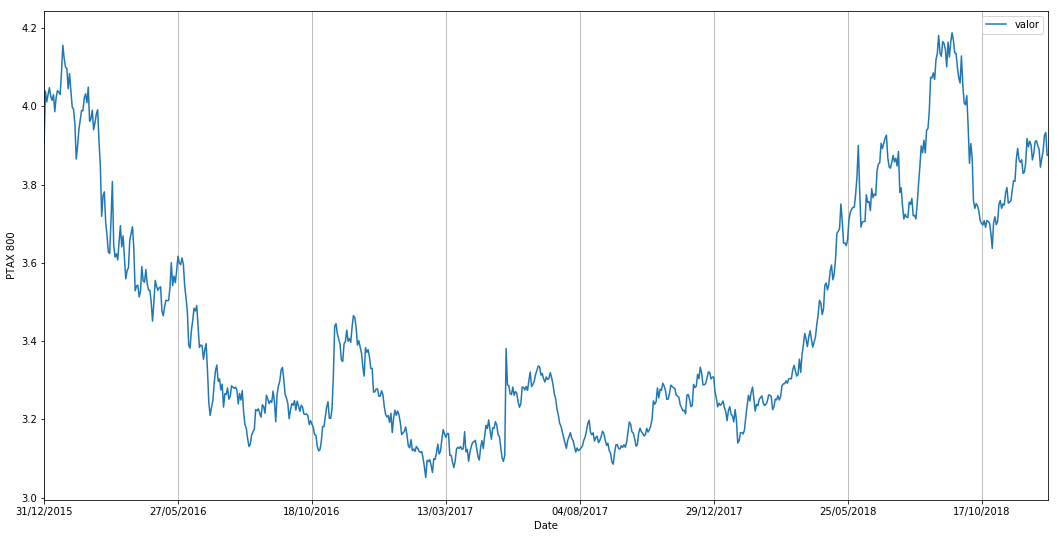

In [7]:
graph(PTAX, 'PTAX 800')

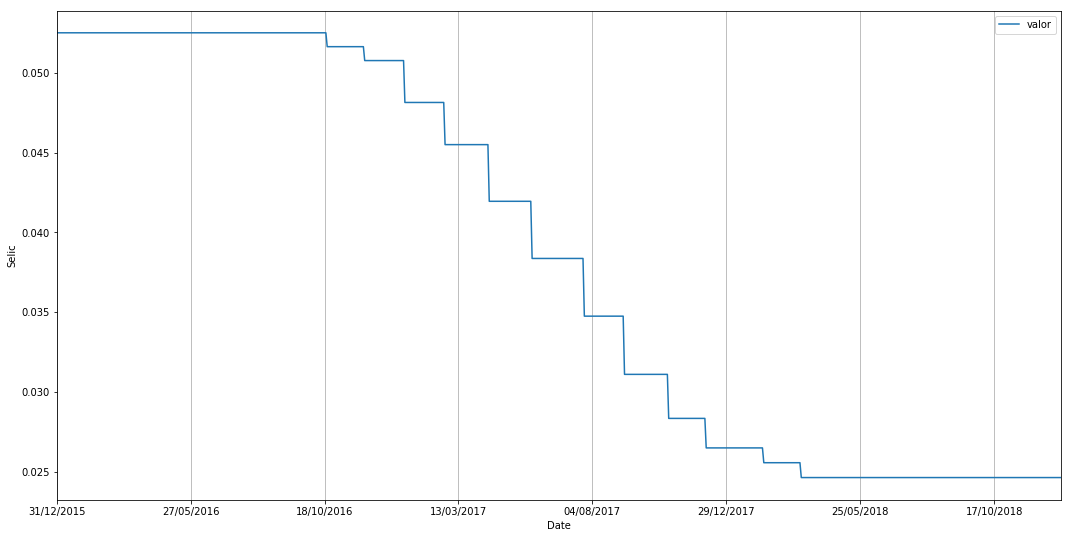

In [8]:
graph(Selic, 'Selic')

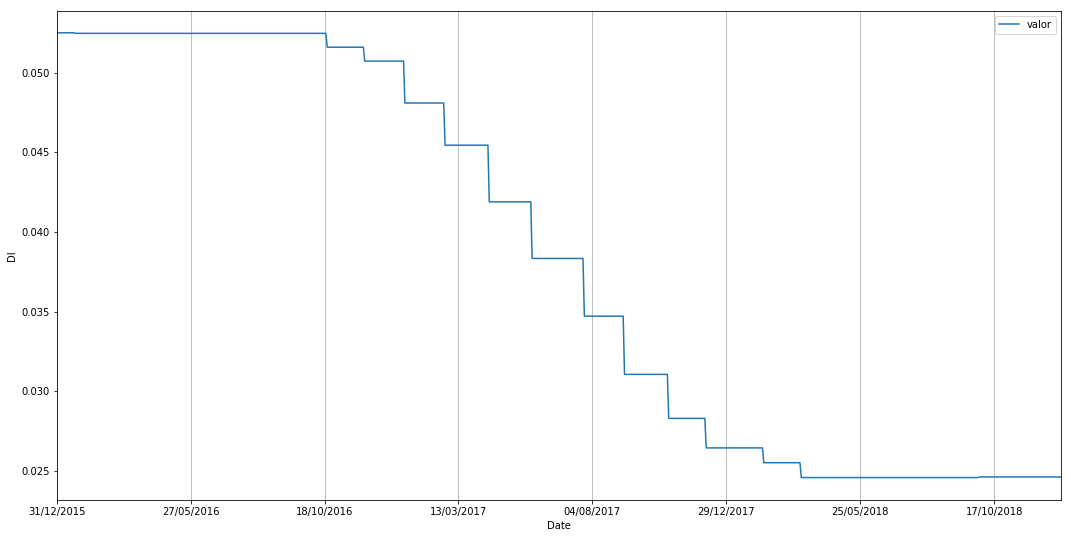

In [9]:
graph(DI, 'DI')

In [10]:
def des_adf_kpss(variables = [], names = []):
    a = ''
    a += '---Descriptive Statistics---'
    for i in range(len(variables)):
        var = variables[i]
        a += '\n{}: mean = {}, standard deviation = {}, minimum = {}, maximum = {}'.format(names[i],
                                                                                 var.mean()[0],
                                                                                 var.std()[0],
                                                                                 var.min()[0],
                                                                                 var.max()[0])     
    a += '\n'
    a += '\n---Augmented Dickey-Fuller---'
    for i in range(len(variables)):
        adf = stat.adfuller(variables[i].valor)
        a += '\n{}: test statistic = {}, critical value at 5% level = {}'.format(names[i],
                                                                                  adf[0],
                                                                                  adf[4]['5%'])
    a += '\n'
    a += '\n---Kwiatkowski–Phillips–Schmidt–Shin---'
    for i in range(len(variables)):
        kpss = stat.kpss(variables[i].valor)
        a += '\n{}: test statistic = {}, critical value at 5% level = {}'.format(names[i],
                                                                                  kpss[0],
                                                                                  kpss[3]['5%'])
    print(a)

In [11]:
des_adf_kpss([PTAX, Selic, DI], ['PTAX', 'Selic', 'DI'])

---Descriptive Statistics---
PTAX: mean = 3.4448865512649784, standard deviation = 0.3050828651457782, minimum = 3.051, maximum = 4.1879
Selic: mean = 0.03846090013315573, standard deviation = 0.01197493491553693, minimum = 0.02462, maximum = 0.052530999999999994
DI: mean = 0.03841205059920091, standard deviation = 0.011956668001639791, minimum = 0.024583, maximum = 0.052496

---Augmented Dickey-Fuller---
PTAX: test statistic = -1.608008315394506, critical value at 5% level = -2.8654117005229844
Selic: test statistic = -0.4014124593315689, critical value at 5% level = -2.8654013553540745
DI: test statistic = -0.4097222032364372, critical value at 5% level = -2.8654013553540745

---Kwiatkowski–Phillips–Schmidt–Shin---
PTAX: test statistic = 0.9224921873948573, critical value at 5% level = 0.463
Selic: test statistic = 3.559665503820358, critical value at 5% level = 0.463
DI: test statistic = 3.559571599294001, critical value at 5% level = 0.463


/Users/bernardopaulsen/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [17]:
def cupom_cambial(juros, usd = PTAX):
    CupomCambialValor = []
    CupomCambialData = []
    for i in range(len(usd.valor)):
        if i >= 1:
            valor = (1+ juros.valor[i]/100)/(usd.valor[i]/usd.valor[i-1])-1
            CupomCambialValor.append(valor)
            CupomCambialData.append(usd.index[i])
    v = {'valor': CupomCambialValor}        
    CupomCambial = pd.DataFrame(v, index = CupomCambialData)
    return(CupomCambial)

In [18]:
CCOC = cupom_cambial(Selic)
CCDI = cupom_cambial(DI)

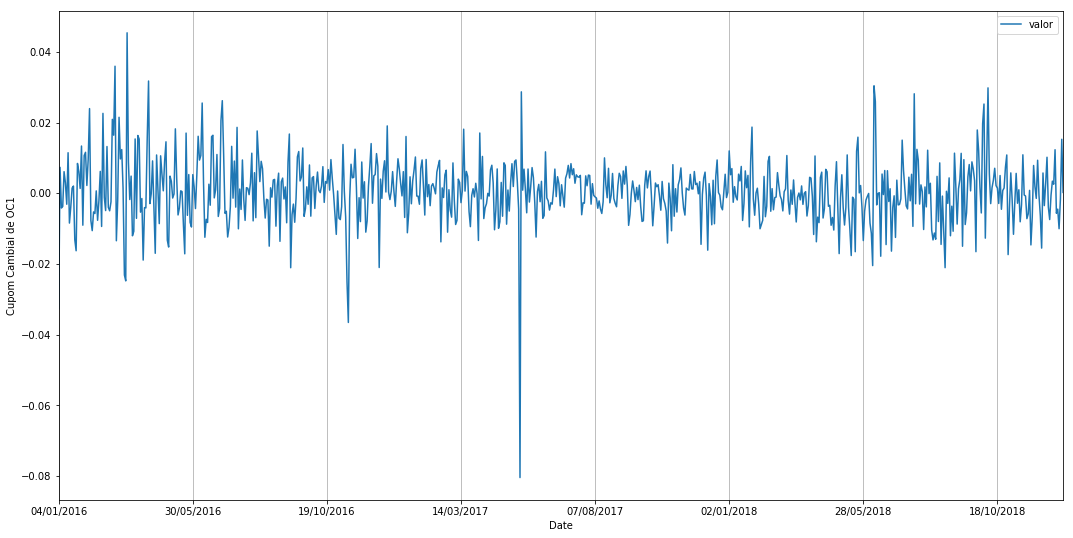

In [19]:
graph(CCOC, 'Cupom Cambial de OC1')

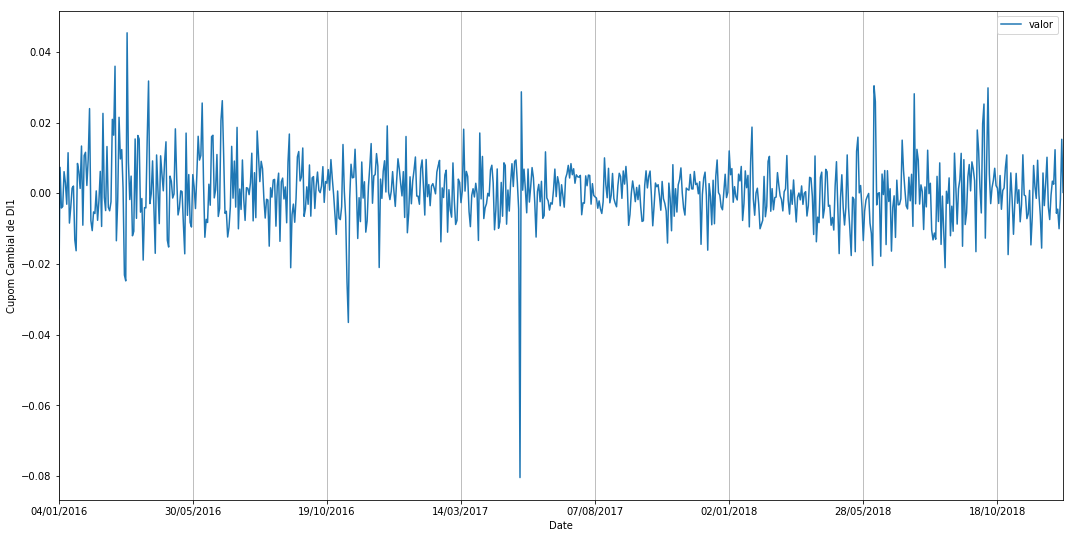

In [20]:
graph(CCDI, 'Cupom Cambial de DI1')

In [21]:
des_adf_kpss([CCOC, CCDI],['Cupom Cambial de OC1', 'Cupom Cambial de DI1'])

---Descriptive Statistics---
Cupom Cambial de OC1: mean = 0.0004366911162233624, standard deviation = 0.009153230820790618, minimum = -0.08039641029017663, maximum = 0.0453835445051447
Cupom Cambial de DI1: mean = 0.00043620232324821136, standard deviation = 0.009153213864702312, minimum = -0.08039706293489524, maximum = 0.045382813120867116

---Augmented Dickey-Fuller---
Cupom Cambial de OC1: test statistic = -20.67022917626957, critical value at 5% level = -2.8654117005229844
Cupom Cambial de DI1: test statistic = -20.670308898795906, critical value at 5% level = -2.8654117005229844

---Kwiatkowski–Phillips–Schmidt–Shin---
Cupom Cambial de OC1: test statistic = 0.5050516094069376, critical value at 5% level = 0.463
Cupom Cambial de DI1: test statistic = 0.5048490686914683, critical value at 5% level = 0.463


In [25]:
GarchOC = arch_model(CCOC.valor)
ResultadoGarchOC = GarchOC.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -2482.2493766308053
Iteration:      2,   Func. Count:     19,   Neg. LLF: -2482.355992641309
Iteration:      3,   Func. Count:     31,   Neg. LLF: -2482.357536127786
Iteration:      4,   Func. Count:     44,   Neg. LLF: -2482.35767945077
Iteration:      5,   Func. Count:     56,   Neg. LLF: -2482.357826065624
Iteration:      6,   Func. Count:     69,   Neg. LLF: -2482.358012220451
Iteration:      7,   Func. Count:     82,   Neg. LLF: -2482.3580190247894
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2482.3580187339057
            Iterations: 10
            Function evaluations: 91
            Gradient evaluations: 7


In [26]:
GarchDI = arch_model(CCDI.valor)
ResultadoGarchDI = GarchDI.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -2482.2509270342034
Iteration:      2,   Func. Count:     19,   Neg. LLF: -2482.357499570863
Iteration:      3,   Func. Count:     32,   Neg. LLF: -2482.3582909665392
Iteration:      4,   Func. Count:     45,   Neg. LLF: -2482.358297029792
Iteration:      5,   Func. Count:     57,   Neg. LLF: -2482.358299620193
Iteration:      6,   Func. Count:     67,   Neg. LLF: -2482.4070871446065
Iteration:      7,   Func. Count:     80,   Neg. LLF: -2482.436859008246
Iteration:      8,   Func. Count:     93,   Neg. LLF: -2482.4370402044
Iteration:      9,   Func. Count:    105,   Neg. LLF: -2482.437042286345
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2482.4370420734977
            Iterations: 13
            Function evaluations: 116
            Gradient evaluations: 9


In [44]:
def ljung_shapiro(variables = [], names = []):
    a = ''
    a += '---Ljung-Box Test---'
    for i in range(len(variables)):
        var = variables[i]
        a += '\n{}: p-value = {}'.format(names[i],
                                         dig.acorr_ljungbox(var, lags=1)[1][0],
                                        )     
    a += '\n'
    a += '\n---Shpairo-Wilk Test---'
    for i in range(len(variables)):
        var = variables[i]
        a += '\n{}: p-value = {}'.format(names[i],
                                         stats.shapiro(var)[1],
                                        )
    print(a)

In [45]:
ljung_shapiro([ResultadoGarchOC.resid, ResultadoGarchDI.resid], ['Resíduos GARCH OC1', 'Resíduos GARCH DI1'])

---Ljung-Box Test---
Resíduos GARCH OC1: p-value = 0.5205117117033824
Resíduos GARCH DI1: p-value = 0.5205549932383521

---Shpairo-Wilk Test---
Resíduos GARCH OC1: p-value = 5.643262298901639e-18
Resíduos GARCH DI1: p-value = 5.64293556255968e-18


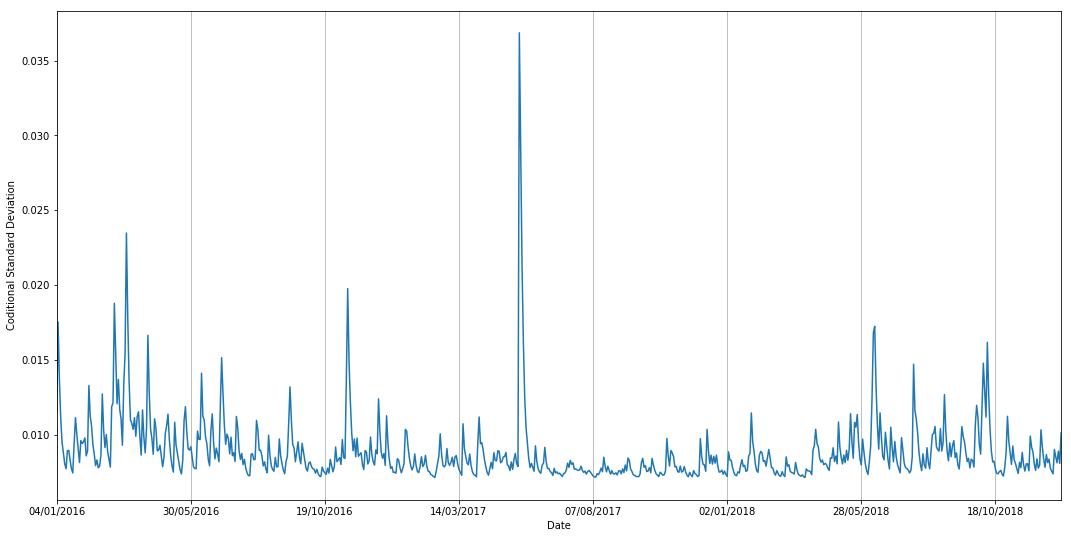

In [27]:
graph(ResultadoGarchOC.conditional_volatility, 'Coditional Standard Deviation')

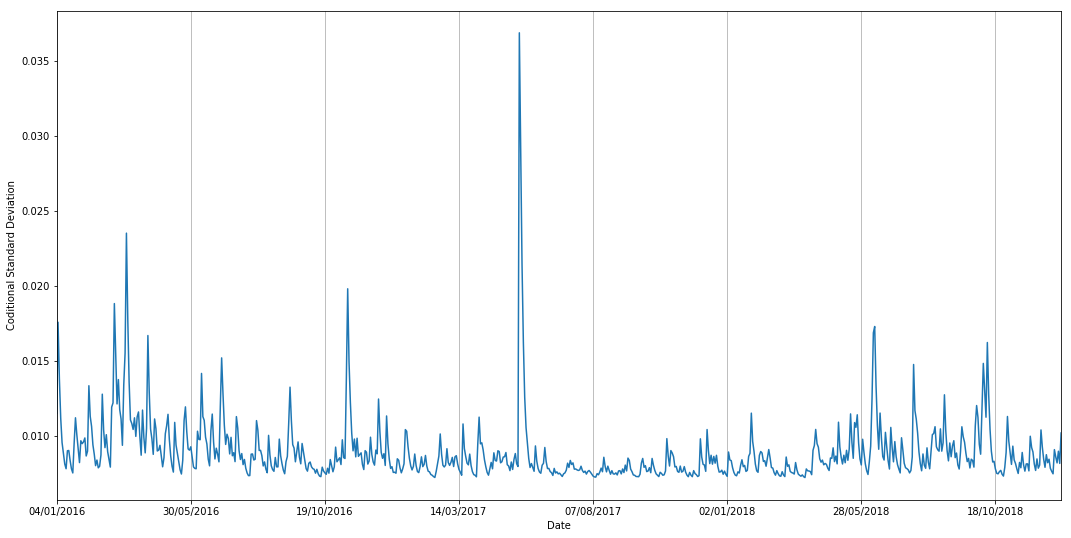

In [28]:
graph(ResultadoGarchDI.conditional_volatility, 'Coditional Standard Deviation')

In [29]:
def des(variables = [], names = []):
    a = ''
    a += '---Descriptive Statistics---'
    for i in range(len(variables)):
        var = variables[i]
        a += '\n{}: mean = {}, standard deviation = {}, minimum = {}, maximum = {}'.format(names[i],
                                                                                 var.mean(),
                                                                                 var.std(),
                                                                                 var.min(),
                                                                                 var.max())
    print(a)

In [30]:
des([ResultadoGarchOC.conditional_volatility, ResultadoGarchDI.conditional_volatility],['Cupom Cambial de OC1', 'Cupom Cambial de DI1'])

---Descriptive Statistics---
Cupom Cambial de OC1: mean = 0.008877291792304311, standard deviation = 0.002243464244352331, minimum = 0.007147643676200297, maximum = 0.03685756142872235
Cupom Cambial de DI1: mean = 0.008918515161965393, standard deviation = 0.0022374344274453217, minimum = 0.0071970286545097835, maximum = 0.03685973168883717


In [31]:
def lim(v):
    mais = []
    menos = []
    data = []
    
    confidence = 0.95
    n = len(v)
    m = mean(v)
    std_err = stats.sem(v)
    h = std_err * stats.t.ppf((1 + confidence) / 2,  n - 1)

    for i in range(len(v.values)):
        mais.append(m + h)
        menos.append(m - h)
        data.append(v.index[i])
    va = {'Upper_Limit': mais, 'Lower_Limit': menos}        
    T = pd.DataFrame(va, index = data)
    return(T)

In [32]:
LimOC = lim(ResultadoGarchOC.conditional_volatility)
LimDI = lim(ResultadoGarchDI.conditional_volatility)

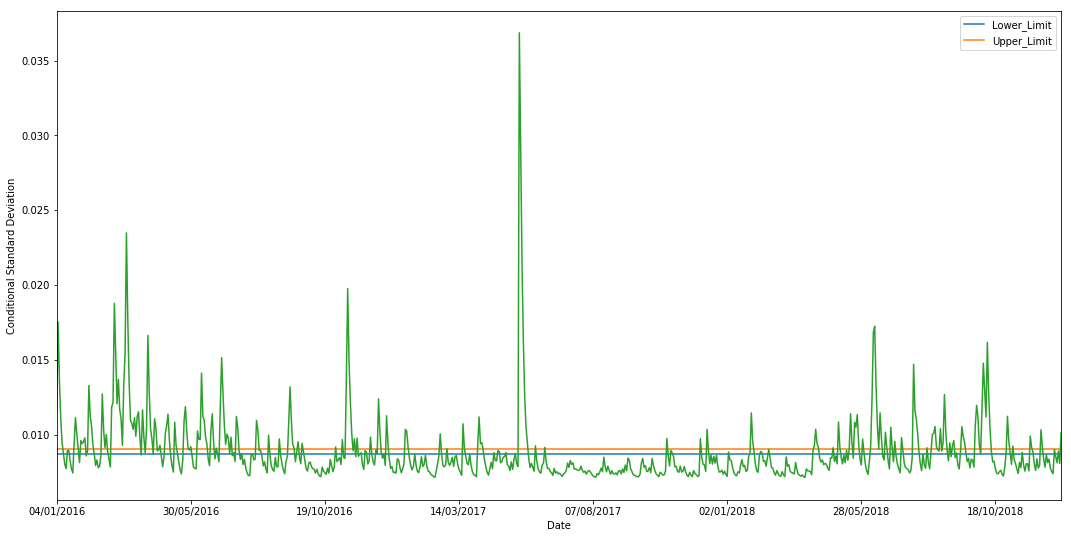

In [33]:
LimOC.plot(figsize = (18,9))
plt.xlabel('Date')
plt.ylabel('Conditional Standard Deviation')
ResultadoGarchOC.conditional_volatility.plot(figsize = (18,9))
plt.show()

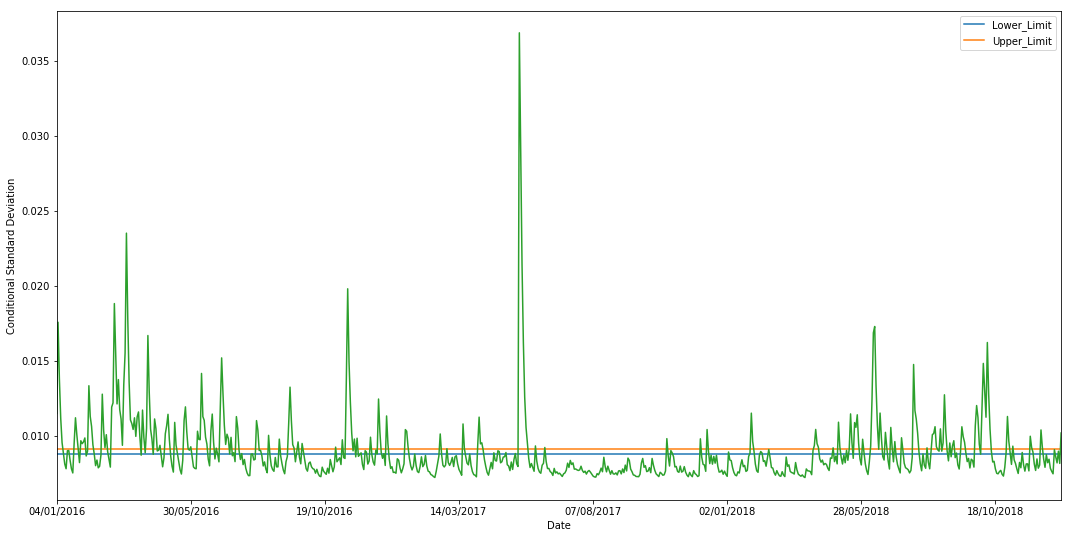

In [34]:
LimDI.plot(figsize = (18,9))
plt.xlabel('Date')
plt.ylabel('Conditional Standard Deviation')
ResultadoGarchDI.conditional_volatility.plot(figsize = (18,9))
plt.show()

In [35]:
def maior(resultado, l, nome):
    datas = []
    n = 0
    s = '---Dates with Abnormal Volatility for {}---'.format(nome)
    for i in range(len(l.index)):
        if resultado[i] > l.Upper_Limit[i]:
            datas.append(l.index[i])
            n += 1
        elif resultado[i] < l.Lower_Limit[i]:
            n += 1
            datas.append(l.index[i])
    for i in range(len(datas)):
        s += '\nDay number {}: {}'.format((i+1), datas[i])
    s += '\nDays with abnarmal volatility: {}'.format(n)
    print(s)

In [36]:
maior(ResultadoGarchOC.conditional_volatility, lim(ResultadoGarchOC.conditional_volatility), 'OC')

---Dates with Abnormal Volatility for OC---
Day number 1: 04/01/2016
Day number 2: 05/01/2016
Day number 3: 06/01/2016
Day number 4: 07/01/2016
Day number 5: 08/01/2016
Day number 6: 12/01/2016
Day number 7: 13/01/2016
Day number 8: 18/01/2016
Day number 9: 19/01/2016
Day number 10: 20/01/2016
Day number 11: 21/01/2016
Day number 12: 22/01/2016
Day number 13: 25/01/2016
Day number 14: 26/01/2016
Day number 15: 27/01/2016
Day number 16: 28/01/2016
Day number 17: 29/01/2016
Day number 18: 01/02/2016
Day number 19: 02/02/2016
Day number 20: 03/02/2016
Day number 21: 05/02/2016
Day number 22: 10/02/2016
Day number 23: 11/02/2016
Day number 24: 12/02/2016
Day number 25: 16/02/2016
Day number 26: 17/02/2016
Day number 27: 18/02/2016
Day number 28: 19/02/2016
Day number 29: 22/02/2016
Day number 30: 23/02/2016
Day number 31: 24/02/2016
Day number 32: 25/02/2016
Day number 33: 26/02/2016
Day number 34: 01/03/2016
Day number 35: 02/03/2016
Day number 36: 03/03/2016
Day number 37: 04/03/2016
Day

In [37]:
maior(ResultadoGarchDI.conditional_volatility, lim(ResultadoGarchDI.conditional_volatility), 'DI')

---Dates with Abnormal Volatility for DI---
Day number 1: 04/01/2016
Day number 2: 05/01/2016
Day number 3: 06/01/2016
Day number 4: 07/01/2016
Day number 5: 08/01/2016
Day number 6: 12/01/2016
Day number 7: 13/01/2016
Day number 8: 18/01/2016
Day number 9: 19/01/2016
Day number 10: 20/01/2016
Day number 11: 21/01/2016
Day number 12: 22/01/2016
Day number 13: 25/01/2016
Day number 14: 26/01/2016
Day number 15: 27/01/2016
Day number 16: 28/01/2016
Day number 17: 29/01/2016
Day number 18: 01/02/2016
Day number 19: 02/02/2016
Day number 20: 03/02/2016
Day number 21: 05/02/2016
Day number 22: 10/02/2016
Day number 23: 11/02/2016
Day number 24: 12/02/2016
Day number 25: 16/02/2016
Day number 26: 17/02/2016
Day number 27: 18/02/2016
Day number 28: 19/02/2016
Day number 29: 22/02/2016
Day number 30: 23/02/2016
Day number 31: 24/02/2016
Day number 32: 25/02/2016
Day number 33: 26/02/2016
Day number 34: 01/03/2016
Day number 35: 02/03/2016
Day number 36: 03/03/2016
Day number 37: 04/03/2016
Day

In [38]:
def limite(v):
    mais = []
    menos = []
    data = []
    maior = v.mean() + (stats.norm.ppf(q = 0.975) * (v.std()))
    menor = v.mean() - (stats.norm.ppf(q = 0.975) * (v.std()))
    for i in range(len(v.values)):
        mais.append(maior)
        menos.append(menor)
        data.append(v.index[i])
    va = {'Upper_Limit': mais, 'Lower_Limit': menos}        
    T = pd.DataFrame(va, index = data)
    return(T)

In [39]:
LimiteOC = limite(ResultadoGarchOC.conditional_volatility)
LimiteDI = limite(ResultadoGarchDI.conditional_volatility)

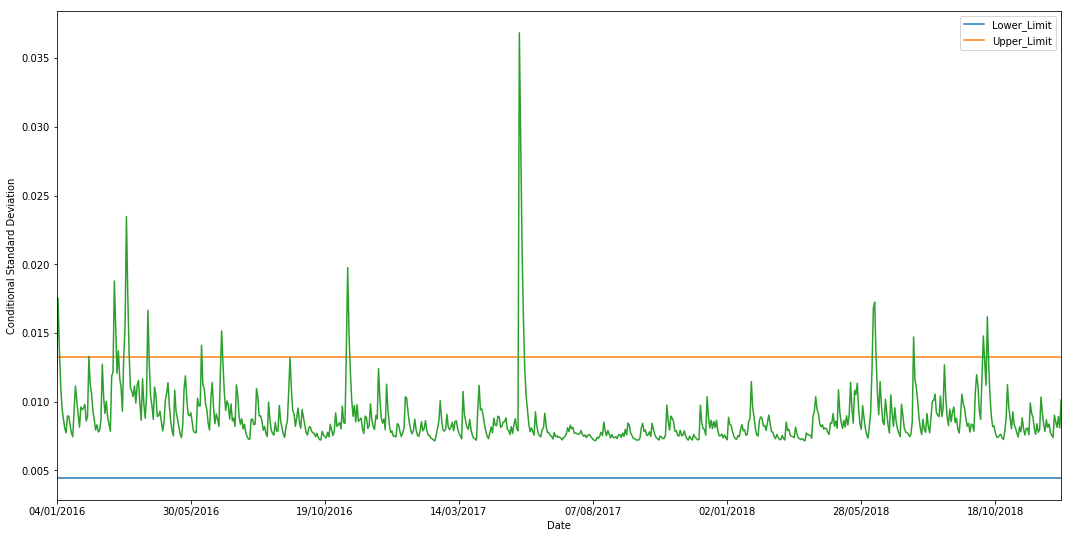

In [40]:
LimiteOC.plot(figsize = (18,9))
plt.xlabel('Date')
plt.ylabel('Conditional Standard Deviation')
ResultadoGarchOC.conditional_volatility.plot(figsize = (18,9))
plt.show()

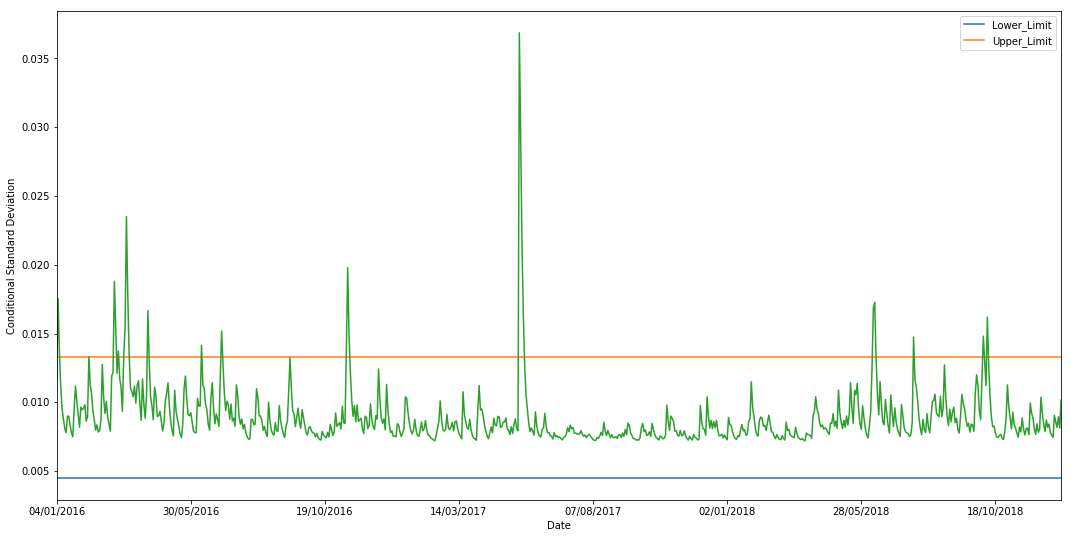

In [41]:
LimiteDI.plot(figsize = (18,9))
plt.xlabel('Date')
plt.ylabel('Conditional Standard Deviation')
ResultadoGarchDI.conditional_volatility.plot(figsize = (18,9))
plt.show()

In [42]:
maior(ResultadoGarchOC.conditional_volatility, limite(ResultadoGarchOC.conditional_volatility), 'OC')

---Dates with Abnormal Volatility for OC---
Day number 1: 05/01/2016
Day number 2: 06/01/2016
Day number 3: 05/02/2016
Day number 4: 07/03/2016
Day number 5: 08/03/2016
Day number 6: 10/03/2016
Day number 7: 16/03/2016
Day number 8: 17/03/2016
Day number 9: 18/03/2016
Day number 10: 21/03/2016
Day number 11: 22/03/2016
Day number 12: 12/04/2016
Day number 13: 09/06/2016
Day number 14: 30/06/2016
Day number 15: 11/11/2016
Day number 16: 14/11/2016
Day number 17: 16/11/2016
Day number 18: 19/05/2017
Day number 19: 22/05/2017
Day number 20: 23/05/2017
Day number 21: 24/05/2017
Day number 22: 11/06/2018
Day number 23: 12/06/2018
Day number 24: 13/06/2018
Day number 25: 23/07/2018
Day number 26: 04/10/2018
Day number 27: 09/10/2018
Days with abnarmal volatility: 27


In [43]:
maior(ResultadoGarchDI.conditional_volatility, limite(ResultadoGarchDI.conditional_volatility), 'OC')

---Dates with Abnormal Volatility for OC---
Day number 1: 05/01/2016
Day number 2: 06/01/2016
Day number 3: 05/02/2016
Day number 4: 07/03/2016
Day number 5: 08/03/2016
Day number 6: 10/03/2016
Day number 7: 16/03/2016
Day number 8: 17/03/2016
Day number 9: 18/03/2016
Day number 10: 21/03/2016
Day number 11: 22/03/2016
Day number 12: 12/04/2016
Day number 13: 09/06/2016
Day number 14: 30/06/2016
Day number 15: 11/11/2016
Day number 16: 14/11/2016
Day number 17: 16/11/2016
Day number 18: 19/05/2017
Day number 19: 22/05/2017
Day number 20: 23/05/2017
Day number 21: 24/05/2017
Day number 22: 11/06/2018
Day number 23: 12/06/2018
Day number 24: 13/06/2018
Day number 25: 23/07/2018
Day number 26: 04/10/2018
Day number 27: 09/10/2018
Days with abnarmal volatility: 27


In [46]:
ljung_shapiro([ResultadoGarchOC.conditional_volatility, ResultadoGarchDI.conditional_volatility], ['OC', 'DI'])

---Ljung-Box Test---
OC: p-value = 1.9874013812350458e-80
DI: p-value = 2.082075255494755e-80

---Shpairo-Wilk Test---
OC: p-value = 8.384686176869115e-39
DI: p-value = 7.72997991615806e-39


In [47]:
stats.norm.ppf(q = 0.975)

1.959963984540054

In [49]:
type(np.array(ResultadoGarchDI.conditional_volatility))

numpy.ndarray

In [50]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

print(bs.bootstrap(np.array(ResultadoGarchDI.conditional_volatility), stat_func=bs_stats.mean))

0.008918515161965393    (0.008754320928471927, 0.009070129405482137)


In [51]:
'''

https://pypi.org/project/bootstrapped/

https://arch.readthedocs.io/en/latest/bootstrap/confidence-intervals.html#nonparametric-confidence-intervals



'''

'\n\nhttps://pypi.org/project/bootstrapped/\n\nhttps://arch.readthedocs.io/en/latest/bootstrap/confidence-intervals.html#nonparametric-confidence-intervals\n\n\n\n'

In [52]:
def func(x):
    return x.mean()
from arch.bootstrap import IIDBootstrap
bs = IIDBootstrap(ResultadoGarchDI.conditional_volatility)
ci = bs.conf_int(func, 1000)

In [53]:
ci

array([[ 0.00876412],
       [ 0.00906831]])

In [54]:
def sharpe_ratio(x):
    mu, sigma = x.mean(), np.sqrt(x.var())
    return np.array([mu, sigma])

from arch.bootstrap import IIDBootstrap

bs = IIDBootstrap(ResultadoGarchDI.conditional_volatility)
ci = bs.conf_int(sharpe_ratio, 1000, method='percentile')

In [55]:
ci

array([[ 0.00875839,  0.00169077],
       [ 0.00908412,  0.00275037]])

In [56]:
def bootstrap(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

In [57]:
boot = bootstrap(ResultadoGarchDI.conditional_volatility)

In [58]:
cintervals = boot(.95)
print(cintervals)

(0.0087718435289599536, 0.0090777604899444954)


\begin{table}[H]
\caption{Descriptive Statistics}
\label{tab:ptaxselicdi}
\centering
\begin{tabular}{ | c | c | c | c | c | }
\hline
Series & Mean & Standard Deviation & Minimum Value & Maximum Value \\
\hline \hline
Dollar Exchange Rate & 3.424 & 0.314 & 3.051 & 4.187 \\
\hline
Referential Rate of the Selic & 0.031 & 0.008 & 0.024 & 0.050 \\
\hline
Interbank Deposit Rate & 0.031 & 0.008 & 0.024 & 0.050 \\
\hline
\end{tabular}
\end{table}

\begin{table}[H]
\caption{Augmented Dickey-Fuller Test}
\label{tab:coupon_adf}
\centering
\begin{tabular}{ | c | c | c | }
\hline
Series & Test Statistic & Critical Value at 5\% Level \\
\hline \hline
OC1 Exchange Coupon & -17.091 & -2.867 \\
\hline
DI1 Exchange Coupon & -17.091 & -2.867 \\
\hline
\end{tabular}
\end{table}

\begin{table}[H]
\caption{Kwiatkowski– Phillips–Schmidt–Shin Test}
\label{tab:coupon_kpss}
\centering
\begin{tabular}{ | c | c | c | }
\hline
Series & Test Statistic & Critical Value at 5\% Level \\
\hline \hline
OC1 Exchange Coupon & 0.160 & 0.463 \\
\hline
DI1 Exchange Coupon & 0.160 & 0.463 \\
\hline
\end{tabular}
\end{table}

\begin{table}[H]
\caption{Ljung-Box Test and Shapiro-Wilk Test}
\label{tab:residuals_white}
\centering
\begin{tabular}{ | c | c | c | }
\hline
Series & P-value for Ljung-Box Test & P-value for Shapiro-Wilk Test \\
\hline \hline
OC1 Exchange Coupon & 0.470 & 1.564e-18 \\
\hline
DI1 Exchange Coupon & 0.470 & 1.563e-18 \\
\hline
\end{tabular}
\end{table}

In [48]:
def graphs(var = [], name = [], n = 1):
    n = len(var)
    fig, axs = plt.subplots(nrows=n, figsize=((n*9), 18))
    for i in range(len(var)):
        ax = axs[i]
        ax.plot(var[i].valor)
        ax.set_title(name[i])
    plt.show()

In [6]:
import matplotlib.dates as dt

def graphi(df, name):
    ax = plt.subplots(1, 1)
    ax.plot(df.valor, index=df.index)
    yloc = dt.YearLocator()
    mloc = dt.MonthLocator()
    ax.xaxis.set_major_locator(yloc)
    ax.xaxis.set_minor_locator(mloc)
    ax.grid(True)
    plt.show()

In [12]:
def variacao(a):
    VariacaoValor = []
    VariacaoData = []
    for i in range(len(a.valor)):
        if i >= 1:
            valor = a.valor[i]/a.valor[i-1]-1
            VariacaoValor.append(valor)
            VariacaoData.append(a.index[i])
    v = {'valor': VariacaoValor}        
    Variacao = pd.DataFrame(v, index = VariacaoData)
    return(Variacao)

In [66]:
# graph(variacao(PTAX), 'Variação PTAX')

In [63]:
# graph(variacao(Selic), 'Variação Selic')

In [62]:
# graph(variacao(DI), 'Variação DI')

In [22]:
def total(v):
    valore = []
    data = []
    t = 1
    d = ''
    for i in range(len(v.valor)):
        t = t*(1+v.valor[i])
        valore.append(t)
        data.append(v.index[i])
    va = {'valor': valore}        
    T = pd.DataFrame(va, index = data)
    return(T)

In [60]:
# graph(total(CCOC), 'Rendimento Total do Cupom Cambial de OC1')

In [61]:
# graph(total(CCDI), 'Rendimento Total do Cupom Cambial de DI1')